In [ ]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DWave Credentials
dwave_solver = os.getenv('DWAVE_API_SOLVER')
api_key = os.getenv('DWAVE_API_TOKEN')

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

### Use NetworkX graphic package to create a signed network
import networkx as nx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [2]:
# Import Asset Class data

dataset = 'asset_class' # values: 'asset_class','ftse','sectors','sp100'

corr_tensor = np.load('../Data/%s/%s_corr.npy' % (dataset, dataset))
dates = np.load('../Data/%s/%s_dates.npy' % (dataset, dataset))
nodes = np.load('../Data/%s/%s_nodes.npy' % (dataset, dataset))
nodes_descr = np.load('../Data/%s/%s_nodes_descr.npy' % (dataset, dataset))

num_examples = corr_tensor.shape[0]
dim = corr_tensor.shape[1]

In [273]:
num_examples

120

In [274]:
dim

19

In [4]:
# Helper Functions

def make_graph(corr_mat, node_labels, graph_type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if graph_type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if graph_type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] != 0.0:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if graph_type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0:
                    G.add_edge(node_labels[i], node_labels[j])
    
    density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G, density

In [5]:
# Test to see if DW comp. is working
corr_mat = corr_tensor[20, :, :].copy()
        
corr_mat[(corr_mat > -1*0.7) & (corr_mat < 0.7)] = 0
G, density = make_graph(corr_mat, nodes, 'signed')

In [6]:
density

0.19883040935672514

/Users/angadkalra/Projects/dwave_ocean/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


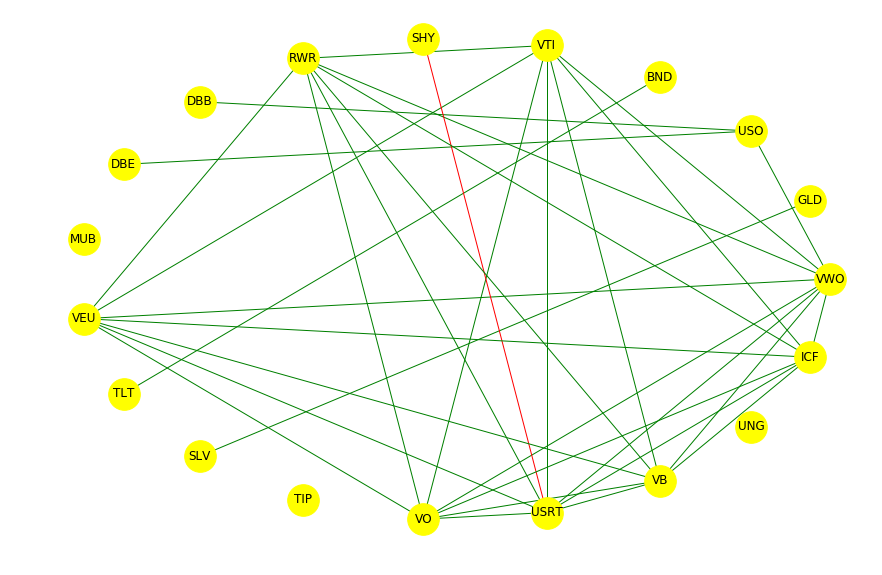

In [7]:
edge_cols = []
for edge in G.edges(data=True):
    if edge[2]["sign"] == -1:
        edge_cols.append("red")
    else:
        edge_cols.append("green")

fig,ax = plt.subplots(figsize=(15,10))
nx.draw_shell(G, ax=ax, with_labels=True, node_size=1000, node_color="yellow", 
              edge_color=edge_cols)
fig.savefig('../ReportFiguresPlots/StructBalance/GraphVisual/%s_after.png'%(dataset))

In [297]:
# Test to see if DW comp. is working
imbalance, bicoloring = dnx.structural_imbalance(G, sampler)
frustration_score = len(list(imbalance.keys()))/G.number_of_edges()

In [298]:
imbalance

{}

In [299]:
frustration_score

0.0

In [300]:
bicoloring

{'BND': 0,
 'DBB': 0,
 'DBE': 0,
 'GLD': 0,
 'ICF': 1,
 'MUB': 1,
 'RWR': 1,
 'SHY': 0,
 'SLV': 0,
 'TIP': 1,
 'TLT': 0,
 'UNG': 0,
 'USO': 0,
 'USRT': 1,
 'VB': 1,
 'VEU': 1,
 'VO': 1,
 'VTI': 1,
 'VWO': 1}

/Users/angadkalra/Projects/dwave_ocean/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


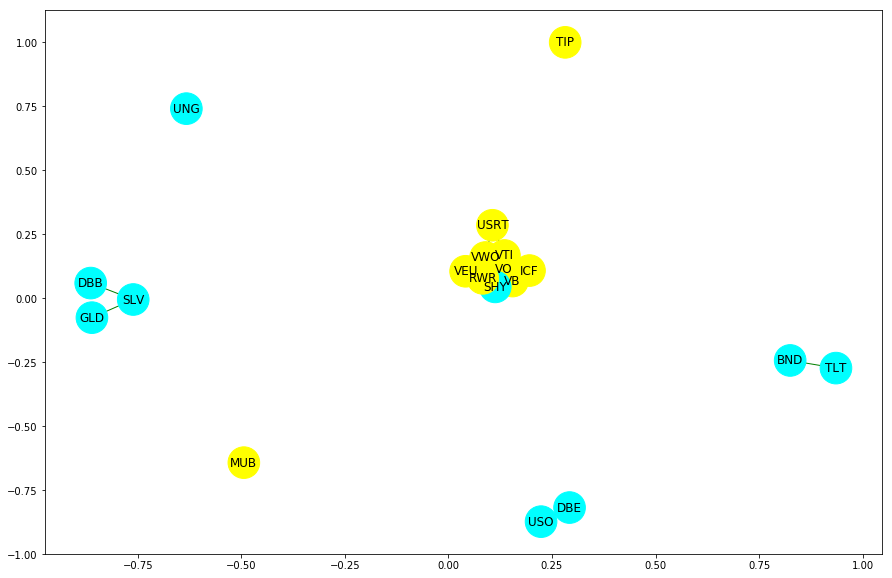

In [302]:
new_bicoloring = {}
for node, color in bicoloring.items():
    new_bicoloring[node] = 'yellow' if color == 1 else 'cyan'

edge_cols = []
frustrated_edges = imbalance.keys()
for edge in G.edges(data=True):
    if (edge[0],edge[1]) in frustrated_edges:
        edge_cols.append("black")
    elif edge[2]["sign"] == -1:
        edge_cols.append("red")
    else:
        edge_cols.append("green")

fig,ax = plt.subplots(figsize=(15,10))
nx.draw_networkx(G, ax=ax, with_labels=True, node_size=1000, node_color=list(new_bicoloring.values()),
                edge_color=edge_cols)

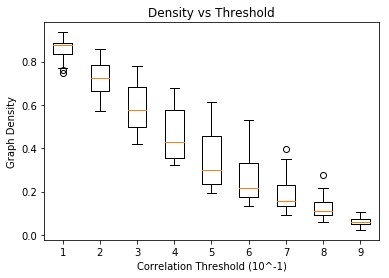

In [276]:
# Plot graph density for each threshold. 
thresh_array = []
density_distr = []

for i in np.arange(0.1, 1, 0.1):
    density_array = []
    for j in range(1, int(num_examples/5)):
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        G, density = make_graph(corr_mat, nodes, 'signed')
        
        density_array.append(density)
    
    density_distr.append(density_array)

plt.boxplot(density_distr)
plt.ylabel("Graph Density")
plt.xlabel("Correlation Threshold (10^-1)")
plt.title("Density vs Threshold")
plt.show()

In [ ]:
# Create graph for each month and calculate frustration. 

frustration_array = []
bicoloring_array = []
date_array = []
density_array = []
threshold_array = []

count = 0
for i in np.arange(0.7, 1, 0.1):
    for j in range(1, int(num_examples/5)):
        
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        
        G, density = make_graph(corr_mat, nodes, 'signed')

        try:
            opt_imbalance, opt_bicoloring = dnx.structural_imbalance(G, sampler)
            opt_score = len(list(imbalance.keys()))/G.number_of_edges()
            
            if opt_score > 0.00:
                for k in range(3):
                    imbalance, bicoloring = dnx.structural_imbalance(G, sampler)
                    frustration_score = len(list(imbalance.keys()))/G.number_of_edges()
                    
                    if frustration_score < opt_score:
                        opt_imbalance = imbalance
                        opt_bicoloring = bicoloring
                        opt_score = frustration_score
                        
            count += 1
            
            if count % 10 == 0:
                print("iteration: i = %f, j = %d" % (i,j))
                
        except Exception as err:
            print(err)
            print("No soln found for threshold %f and matrix %d" % (i, int(j*5)))
        else:
            threshold_array.append(i)
            frustration_array.append(opt_score)
            bicoloring_array.append(opt_bicoloring)
            density_array.append(density)
            date_array.append(dates[j*5])
            

In [ ]:
assert len(frustration_array) == len(date_array) == len(density_array) == len(threshold_array)

In [ ]:
len(frustration_array)

In [ ]:
# Create Pandas DataFrame for results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array, 
                   "frustration_score": frustration_array, 
                   "bicoloring": bicoloring_array}).to_csv("ResultCSVs/structbal_quant_%s_res.csv" % (dataset))